# Spatial Dataset Pre-Processing (Multiple Slices)
Script that converts a pre-processed AnnData object from STARmap/SPARTseq to a Vitessce-compatible Zarr file format. 

**Input:** AnnData Object for Spatial Data 

**Output:** Zarr File 

### Load Packages

In [1]:
import anndata as ad 
import scanpy as sc
import numpy as np
import pandas as pd 
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os

from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
)
from vitessce.data_utils import (
    optimize_adata,
    VAR_CHUNK_SIZE,
)

warnings.simplefilter(action="ignore", category=Warning)

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

print("All packages loaded successfully!")

All packages loaded successfully!


### Set Directory 
Modify the `path` below to your directory that includes the dataset (AnnData).  

In [2]:
# change the directory to general to access data 
path = "/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/"
os.chdir(path)
# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris


### Check versions 

In [3]:
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.24.4 scipy==1.9.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 pynndescent==0.5.13


### Load processed STARmap dataset

In [4]:
data = ad.read_h5ad("vitessce-cerebellum/data/e11_cell_types_4-13-25.h5ad")

In [5]:
# see dimensions of dataset
data 

AnnData object with n_obs × n_vars = 25341 × 1742
    obs: 'cell_number', 'library_id', 'timepoint', 'batch', 'n_genes_by_counts', 'total_counts', 'n_counts', 'leiden', 'cell_types', 'finer_cell_types'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_types_colors', 'finer_cell_types_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial', 'spatial3d'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# Get original spatial
spatial = data.obsm["spatial"]
x = spatial[:, 0]
y = spatial[:, 1]

# Get min and max
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# Determine aspect-ratio-preserving scaling
x_range = x_max - x_min
y_range = y_max - y_min
max_range = max(x_range, y_range)

# Scale both to [0, 1000] while preserving relative position
x_scaled = (x - x_min) / max_range * 1000
y_scaled = (y - y_min) / max_range * 1000

# Store back
data.obsm["spatial"] = np.vstack([x_scaled, y_scaled]).T


In [7]:
pd.DataFrame(data.obsm["spatial"], columns=["x", "y"]).describe()

,x,y
count,25341.000000,25341.000000
mean,269.266499,484.561100
std,136.829799,309.025684
min,0.000000,0.000000
25%,142.712052,300.188596
50%,281.308621,519.386095
75%,389.681182,669.198842
max,518.869872,1000.000000


In [8]:
print(519/2)

259.5


In [9]:
data.obsm['spatial'] = data.obsm['spatial'].astype('uint16') # ensure that the spatial coordinates have a JavaScript-compatible integer data type

[<Axes: title={'center': 'Rora'}, xlabel='spatial1', ylabel='spatial2'>]

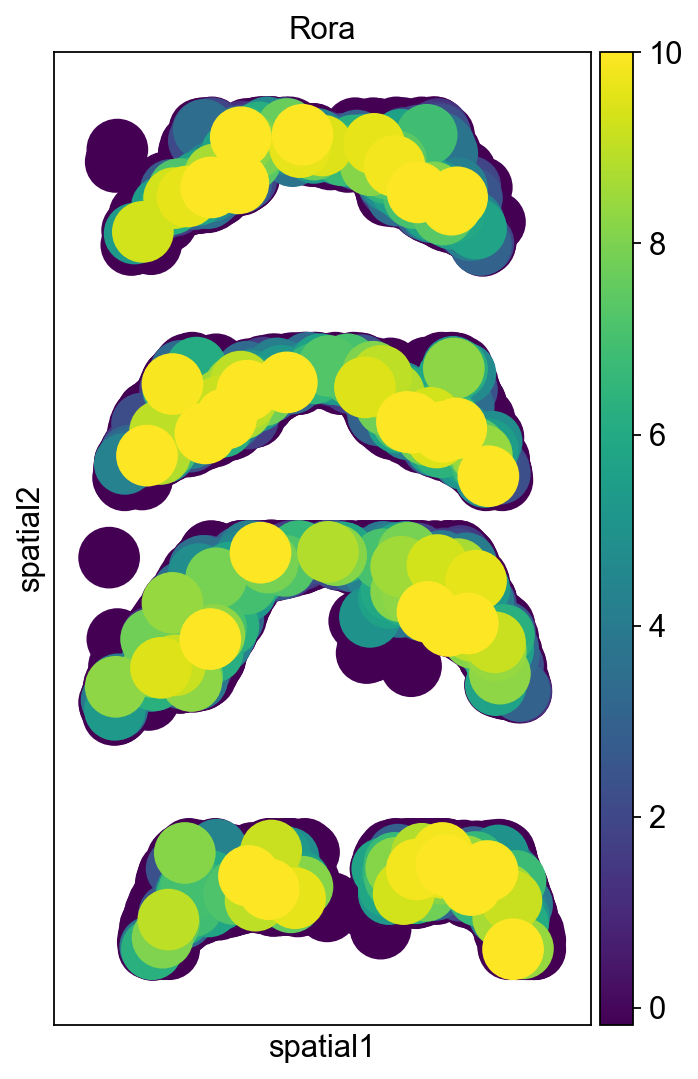

In [10]:
# visualize dataset spatially 
sc.pl.spatial(data, spot_size=75, color="Rora", show=False) 

Save processed data to a Zarr format. 

In [11]:
# change the directory to general to access data 
path = "/Users/iriskwon/Desktop/mouse-cereb-dev/mouse-cereb-dev"
os.chdir(path)

# verify the change
print("New working directory:", os.getcwd())

New working directory: /Users/iriskwon/Desktop/mouse-cereb-dev/mouse-cereb-dev


In [12]:
data.write_zarr("public/data/E11_Normalized.zarr")